# Banking customer churn prediction

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 2. Data Collection and exploration

In [4]:
#load data
df = pd.read_csv(r"/content/sample_data/Bank_churn_modelling.csv")
df.shape

(10000, 14)

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



Analysis:
    
        - Unwanted columns: RowNumber, CustomerId, Surname
        - Demographic info: Age, Gender, geo
        - Financial info: Balance, Salary, creditscore
        - Relation with bank: Tenure, numofproducts, isactivemember
        - Target: Exited
        - Atleast 25% of customers have 0 balance in their account

## 3. Data cleaning

### Handling missing data
    - Data is missing because it does not exist
        - Numeric: convert the column into binary or categorical, add one category as "unavailable"/"others"
        - Categoric: replace all missing values by an additional/existing category "others"/"not known"
        
        
    - Data exists, but it is missing because of some human or system error
        - If any row has more than 60% of values missing - drop the row
        - If any column has more than 70%-80% values missing - drop the column
        - For rows having upto 5%-10% (depending on size of data) missing data - statistical imputation
            - Categoric: Nominal: Mode
            - Categoric: Ordinal: Median
            - Numeric: skewness > 0.1 or skewness < -0.1 => median
            - Numeric: skewness is b/w -0.1 to +0.1 => Mean
          - For rows having more than 10% of data missing: ML based imputation

In [7]:
# check for duplicates
df.duplicated().sum()

0

In [8]:
# check for missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
# Check for data skewness
df[['Tenure','EstimatedSalary']].skew()

Tenure             0.010991
EstimatedSalary    0.002085
dtype: float64

In [10]:
# as skewness is almost 0, the variables are normally distributed, we will impute the missing values by mean
df.Tenure.fillna(df.Tenure.mean(),inplace=True)
df.EstimatedSalary.fillna(df.EstimatedSalary.mean(),inplace=True)

In [11]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
## drop the unwanted columns
print(df.shape)
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)
print(df.shape)

(10000, 14)
(10000, 11)


In [13]:
# check for outliers
df.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


CreditScore       -0.071607
Age                1.011320
Tenure             0.010991
Balance           -0.141109
NumOfProducts      0.745568
HasCrCard         -0.901812
IsActiveMember    -0.060437
EstimatedSalary    0.002085
Exited             1.471611
dtype: float64

## 4. Feature Selection
### Data visualization
#### Univariate Analysis

In [14]:
import plotly.express as px

In [15]:
for col in df.columns:
    fig = px.histogram(df,x=col,width=850,height=400)
    fig.show()

#### Bivariate Analysis

In [16]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [17]:
sns.set_theme()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



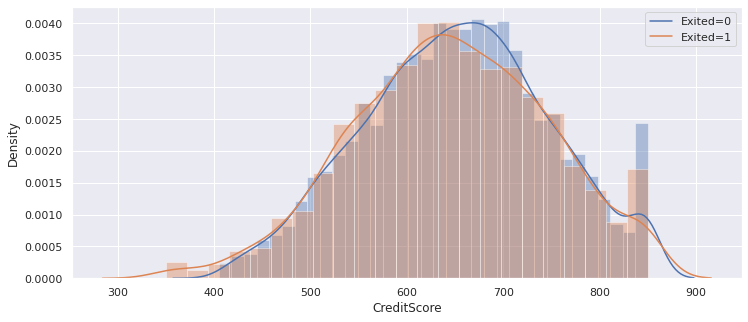

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



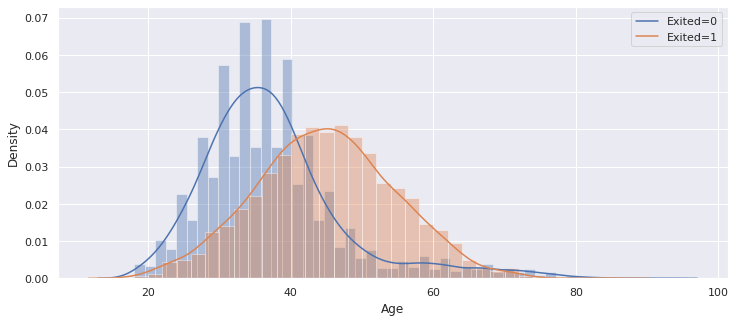

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



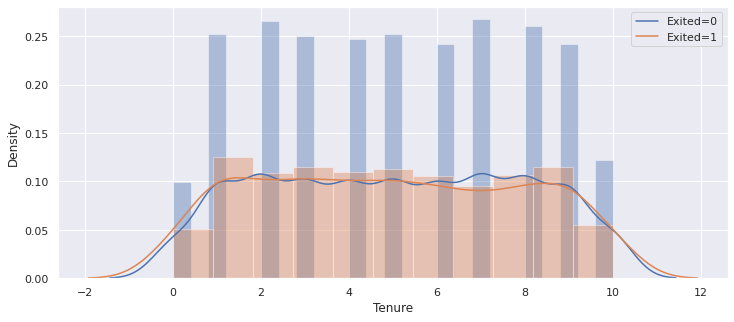

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



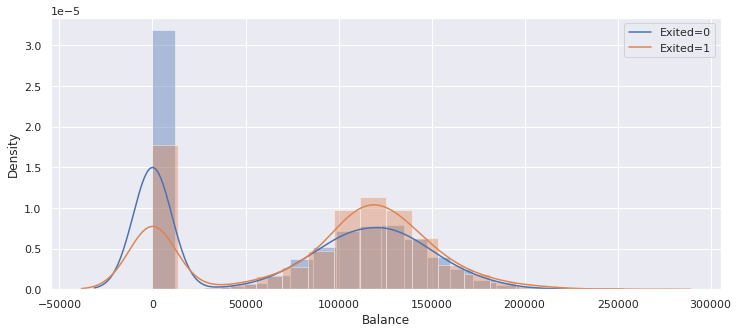

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



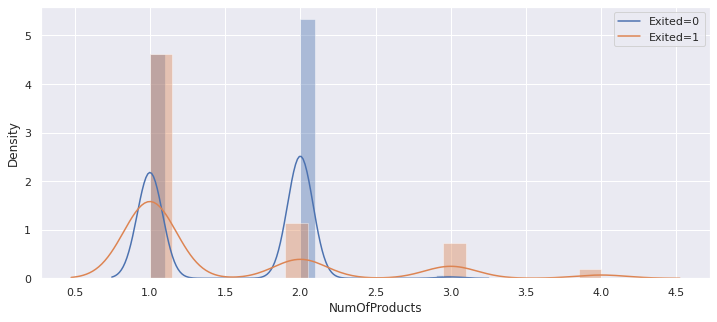

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



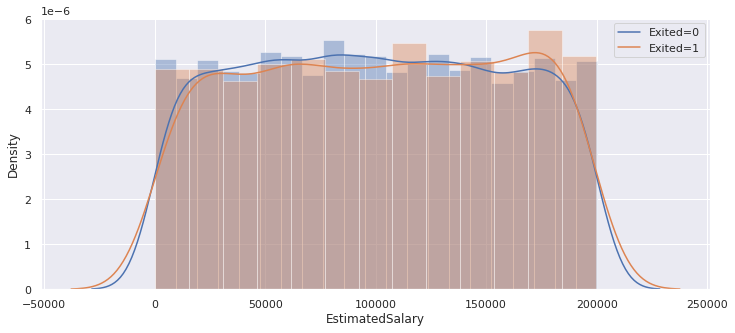

In [18]:
# numeric v/s categoric
nums = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts',  'EstimatedSalary']

for col in nums:
    plt.figure(figsize=(12,5))
    sns.distplot(df[col][df.Exited==0])
    sns.distplot(df[col][df.Exited==1])
    plt.legend(['Exited=0','Exited=1'])
    plt.show()


In [19]:
# Categoric v/s categoric
# geography v/s exited

pivot = pd.crosstab(df.Geography,df.Exited,margins=True)
pivot

Exited,0,1,All
Geography,,,
France,4204,810,5014
Germany,1695,814,2509
Spain,2064,413,2477
All,7963,2037,10000


In [20]:
pivot[1]/pivot['All']

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
All        0.203700
dtype: float64

In [21]:
# Gender v/s Exited
pivot = pd.crosstab(df.Gender,df.Exited,margins=True)
pivot[1] / pivot['All']

Gender
Female    0.250715
Male      0.164559
All       0.203700
dtype: float64

In [22]:
# HasCrCard v/s Exited
pivot = pd.crosstab(df.HasCrCard,df.Exited,margins=True)
pivot[1] / pivot['All']

HasCrCard
0      0.208149
1      0.201843
All    0.203700
dtype: float64

In [23]:
# IsActiveMember v/s Exited
pivot = pd.crosstab(df.IsActiveMember,df.Exited,margins=True)
pivot[1] / pivot['All']

IsActiveMember
0      0.268509
1      0.142691
All    0.203700
dtype: float64

#### Multivariate Analysis

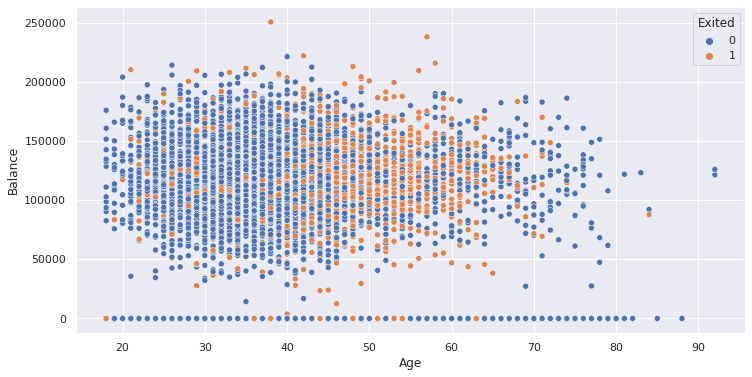

In [24]:
# age v/s Balance v/s Exited
plt.figure(figsize=(12,6))
sns.scatterplot(x='Age',y='Balance',hue='Exited',data=df)
plt.show()

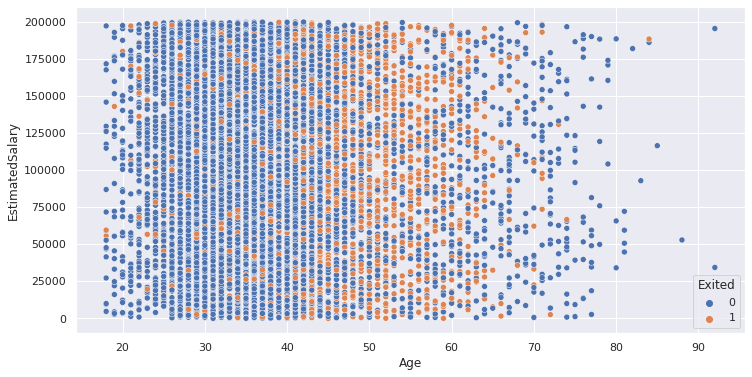

In [25]:
# age v/s EstimatedSalary v/s Exited
plt.figure(figsize=(12,6))
sns.scatterplot(x='Age',y='EstimatedSalary',hue='Exited',data=df)
plt.show()

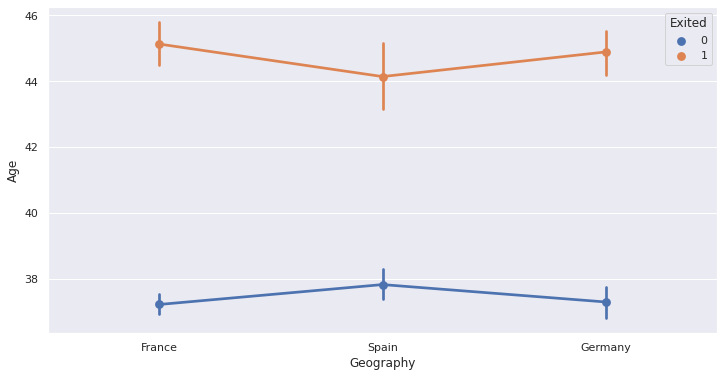

In [26]:
# age v/s Geography v/s Exited
plt.figure(figsize=(12,6))
sns.pointplot(x='Geography',y='Age',hue='Exited',data=df)
plt.show()

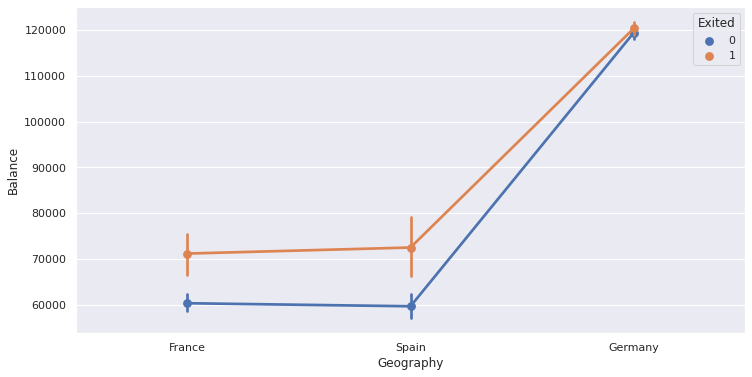

In [27]:
# age v/s Geography v/s Exited
plt.figure(figsize=(12,6))
sns.pointplot(x='Geography',y='Balance',hue='Exited',data=df)
plt.show()

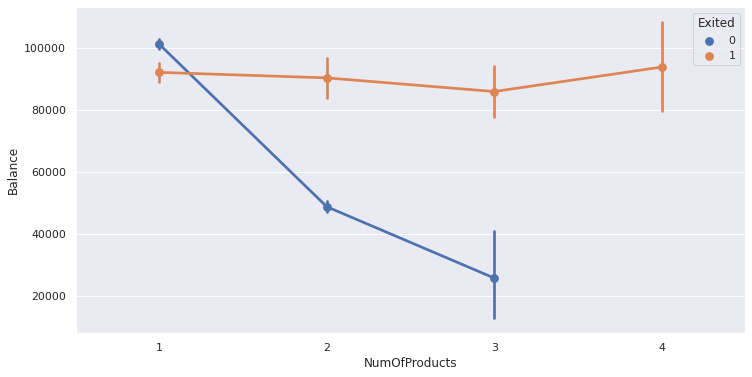

In [28]:
# age v/s Geography v/s Exited
plt.figure(figsize=(12,6))
sns.pointplot(x='NumOfProducts',y='Balance',hue='Exited',data=df)
plt.show()

### statistical research
#### Correlation Analysis

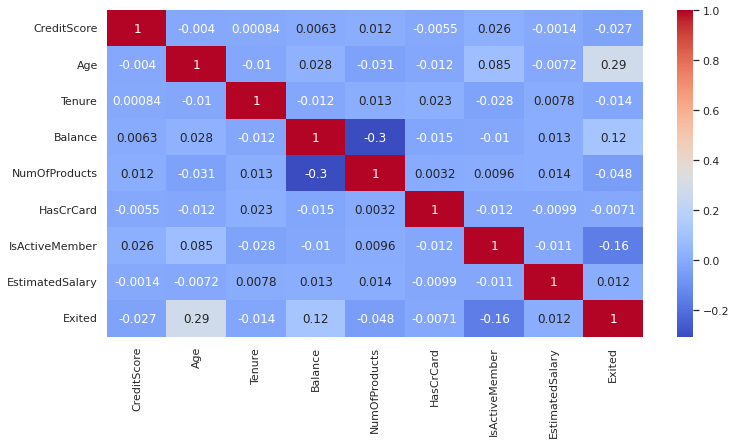

In [29]:
cor = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,annot=True,cmap='coolwarm')
plt.show()

Correlation helps in following way - 

    - it helps in identifying features which are having linear relation with the target attribute
    - In machine learning, supervised ML, there are two types of algorithms
    
        - linear models
            - these are the techniques which primarily learn linear relationship between features and target
            - these mostly lightweight, faster, can give good results with less data
            - can be used if correlation analysis says, most features have good correlation with target attribute
            - linear regression, logistic regression, linear SVM, naive bayes
            
            
        - non linear models
            - these can additionally learn non linear complex relationship between features and target
            - these are heavy, slow, computaionally expensive, need more data to train
            - can be used if features do not have much stronger correlation with target, that means they have mostly some non linear relation with target
            - decision tree, ensemble techniques (random forest, xboost etc.), neural networks


In [30]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [31]:
x = df[['CreditScore', 'Geography', 'Gender', 'Age',  'Balance','NumOfProducts', 'IsActiveMember']]

y = df.Exited

## 5. Preprocessing of features

In [32]:
x.head(8)

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember
0,619,France,Female,42,0.00,1,1
1,608,Spain,Female,41,83807.86,1,1
2,502,France,Female,42,159660.80,3,0
3,699,France,Female,39,0.00,2,0
4,850,Spain,Female,43,125510.82,1,1
5,645,Spain,Male,44,113755.78,2,0
6,822,France,Male,50,0.00,2,1
7,376,Germany,Female,29,115046.74,4,0


In [33]:
pd.get_dummies(df.Gender)

,Female,Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
9995,0,1
9996,0,1
9997,1,0
9998,0,1


In [34]:
# encoding categoric attributes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

prep = ColumnTransformer([('ohe',OneHotEncoder(drop='first'),[1,2]),],remainder='passthrough')
prep.fit(x)

x2 = pd.DataFrame(prep.transform(x))
x2.head(8)

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,619.0,42.0,0.00,1.0,1.0
1,0.0,1.0,0.0,608.0,41.0,83807.86,1.0,1.0
2,0.0,0.0,0.0,502.0,42.0,159660.80,3.0,0.0
3,0.0,0.0,0.0,699.0,39.0,0.00,2.0,0.0
4,0.0,1.0,0.0,850.0,43.0,125510.82,1.0,1.0
5,0.0,1.0,1.0,645.0,44.0,113755.78,2.0,0.0
6,0.0,0.0,1.0,822.0,50.0,0.00,2.0,1.0
7,1.0,0.0,0.0,376.0,29.0,115046.74,4.0,0.0


In [35]:
# train test split
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x2,y,test_size=0.2,random_state=3,stratify=y)
print(x.shape,xtrain.shape,xtest.shape)
print(y.shape,ytrain.shape,ytest.shape)

(10000, 7) (8000, 8) (2000, 8)
(10000,) (8000,) (2000,)


## 6. Apply Machine Learning algorithm

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [37]:
# trianing the model using trrian data
model.fit(xtrain,ytrain)

LogisticRegression()

## 7. Performance Analysis

In [38]:
# age = 25, balance = 120000, nop = 2, gender = male, geo = france, iam = 1, cs=650
newcust =[[650,'France','Male',25,120000,2,1]]
newcust = prep.transform(newcust)
model.predict(newcust)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



array([0])

In [39]:
# we will feed the test data to model to get predictions
ypred = model.predict(xtest)

# accuracy of model on test data
from sklearn import metrics

metrics.accuracy_score(ytest,ypred)

0.7865

In [40]:
# calculating recall
metrics.recall_score(ytest,ypred)

0.044226044226044224

In [41]:
# calculating precision
metrics.precision_score(ytest,ypred)

0.32142857142857145

In [42]:
metrics.f1_score(ytest,ypred)

0.07775377969762419

In [43]:
metrics.confusion_matrix(ytest,ypred)

array([[1555,   38],
       [ 389,   18]])

In [44]:
pd.DataFrame(metrics.confusion_matrix(ytest,ypred))

,0,1
0,1555,38
1,389,18


In [45]:
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1593
           1       0.32      0.04      0.08       407

    accuracy                           0.79      2000
   macro avg       0.56      0.51      0.48      2000
weighted avg       0.70      0.79      0.72      2000



## 5. Preprocessing of features

In [46]:
x.head()

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember
0,619,France,Female,42,0.00,1,1
1,608,Spain,Female,41,83807.86,1,1
2,502,France,Female,42,159660.80,3,0
3,699,France,Female,39,0.00,2,0
4,850,Spain,Female,43,125510.82,1,1


In [47]:
# encoding categoric attributes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

prep = ColumnTransformer([('ohe',OneHotEncoder(drop='first'),[1,2]),('sc',StandardScaler(),[0,3,4,5])],remainder='passthrough')
prep.fit(x)

x2 = pd.DataFrame(prep.transform(x))
x2.head(8)

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,-0.326221,0.293517,-1.225848,-0.911583,1.0
1,0.0,1.0,0.0,-0.440036,0.198164,0.117350,-0.911583,1.0
2,0.0,0.0,0.0,-1.536794,0.293517,1.333053,2.527057,0.0
3,0.0,0.0,0.0,0.501521,0.007457,-1.225848,0.807737,0.0
4,0.0,1.0,0.0,2.063884,0.388871,0.785728,-0.911583,1.0
5,0.0,1.0,1.0,-0.057205,0.484225,0.597329,0.807737,0.0
6,0.0,0.0,1.0,1.774174,1.056346,-1.225848,0.807737,1.0
7,1.0,0.0,0.0,-2.840488,-0.946079,0.618019,4.246377,0.0


In [48]:
# train test split
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x2,y,test_size=0.2,random_state=3,stratify=y)
print(x.shape,xtrain.shape,xtest.shape)
print(y.shape,ytrain.shape,ytest.shape)

(10000, 7) (8000, 8) (2000, 8)
(10000,) (8000,) (2000,)


## 6. Apply Machine Learning algorithm

In [49]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [50]:
# trianing the model using trrian data
model.fit(xtrain,ytrain)

LogisticRegression()

## 7. Performance Analysis

In [51]:
# age = 25, balance = 120000, nop = 2, gender = male, geo = france, iam = 1, cs=650
newcust =[[650,'France','Male',25,120000,2,1]]
newcust = prep.transform(newcust)
model.predict(newcust)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



array([0])

In [52]:
# we will feed the test data to model to get predictions
ypred = model.predict(xtest)

# accuracy of model on test data
from sklearn import metrics

metrics.accuracy_score(ytest,ypred)

0.8115

In [53]:
# calculating recall
metrics.recall_score(ytest,ypred)

0.21375921375921375

In [54]:
# calculating precision
metrics.precision_score(ytest,ypred)

0.6041666666666666

In [55]:
metrics.f1_score(ytest,ypred)

0.31578947368421045

In [56]:
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.60      0.21      0.32       407

    accuracy                           0.81      2000
   macro avg       0.72      0.59      0.60      2000
weighted avg       0.78      0.81      0.77      2000



## KNN Implementation

In [57]:
from sklearn.neighbors import KNeighborsClassifier

model2 = KNeighborsClassifier(n_neighbors=3)
# train the model
model2.fit(xtrain,ytrain)

KNeighborsClassifier(n_neighbors=3)

In [58]:
# assess the performance of model
ypred2 = model2.predict(xtest)

print(metrics.classification_report(ytest,ypred2))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.65      0.53      0.58       407

    accuracy                           0.85      2000
   macro avg       0.77      0.73      0.74      2000
weighted avg       0.84      0.85      0.84      2000



## Decision Tree Implementation

In [59]:
from sklearn import tree

In [60]:
model3 = tree.DecisionTreeClassifier(criterion='gini',random_state=3)
model3.fit(xtrain,ytrain)

DecisionTreeClassifier(random_state=3)

In [61]:
# performance analysis using test data
ypred = model3.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1593
           1       0.49      0.55      0.52       407

    accuracy                           0.79      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.80      0.79      0.80      2000



In [62]:
# performance analysis using train data
ypred = model3.predict(xtrain)
print(metrics.classification_report(ytrain,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6370
           1       1.00      1.00      1.00      1630

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



## Controlling Overfitting

In [63]:
model4 = tree.DecisionTreeClassifier(criterion='gini',random_state=3,max_depth=8,min_samples_leaf=12,
                                    min_samples_split=30)
model4.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=30,
                       random_state=3)

In [64]:
# performance analysis using test data
ypred = model4.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1593
           1       0.70      0.57      0.63       407

    accuracy                           0.86      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.86      0.86      0.86      2000



In [65]:
# performance analysis using train data
ypred = model4.predict(xtrain)
print(metrics.classification_report(ytrain,ypred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6370
           1       0.73      0.58      0.64      1630

    accuracy                           0.87      8000
   macro avg       0.81      0.76      0.78      8000
weighted avg       0.86      0.87      0.86      8000



### Overfitting

    - Performance on test data = low
    - Performance on train data = high
    
#### Why overfitting happens?
    - Presence of noisty observations, noisy features
    - Small data - lack of data
    - Learning algorithm used is more complex
    
#### How to handle overfitting?
    - Drop some unwanted columns, less important columns
    - Collect more data- collect more rows, no need to collect more columns
    - Try a slightly simpler algorithm
    - For decision tree - decrease max params (max_depth, max_leaf_nodes), increase value for min params (min_samples_leaf, min_samples_split).
    
    
### Underfitting

    - Performance of model on test data = low
    - Performance of model on train data = low
    
#### Why underfitting happens?
    - Presence of noisy observations
    - Lack for informative features
    - Learning algorithm used is less efficient
    
#### How to handle underfitting?
    - Drop some noisy rows, outliers
    - Collect more columns, no need collect rows
    - Create/derive new columns
    - Try more complex learning algorithm
    - For decision tree - increase max params (max_depth, max_leaf_nodes), decrease value for min params (min_samples_leaf, min_samples_split).

### Hyperparameter tuning using gridsearch

In [66]:
params = {"max_depth":np.arange(5,12,1),
         'min_samples_leaf':np.arange(5,40,5),
         'min_samples_split':np.arange(5,60,10),
         'max_leaf_nodes':np.arange(30,100,10)}
params

{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11]),
 'max_leaf_nodes': array([30, 40, 50, 60, 70, 80, 90]),
 'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35]),
 'min_samples_split': array([ 5, 15, 25, 35, 45, 55])}

In [67]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(tree.DecisionTreeClassifier(random_state=3),param_grid=params,
                     scoring='f1',cv=5,n_jobs=-1,verbose=True)

In [68]:
search.fit(x2,y)

Fitting 5 folds for each of 2058 candidates, totalling 10290 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=3), n_jobs=-1,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11]),
                         'max_leaf_nodes': array([30, 40, 50, 60, 70, 80, 90]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35]),
                         'min_samples_split': array([ 5, 15, 25, 35, 45, 55])},
             scoring='f1', verbose=True)

In [69]:
search.best_score_

0.5846928858767954

In [70]:
search.best_params_

{'max_depth': 8,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 55}

### Visualize the tree

In [71]:
# encoding categoric attributes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

prep = ColumnTransformer([('ohe',OneHotEncoder(drop='first'),[1,2]),],remainder='passthrough')
prep.fit(x)

x2 = pd.DataFrame(prep.transform(x))
# train test split
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x2,y,test_size=0.2,random_state=3,stratify=y)

In [72]:
prep.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['ohe__x0_Germany',
 'ohe__x0_Spain',
 'ohe__x1_Male',
 'CreditScore',
 'Age',
 'Balance',
 'NumOfProducts',
 'IsActiveMember']

In [73]:
model4 = tree.DecisionTreeClassifier(criterion='gini',random_state=3,max_depth=7,min_samples_leaf=12,
                                    min_samples_split=30,max_leaf_nodes=40)
model4.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=40, min_samples_leaf=12,
                       min_samples_split=30, random_state=3)

In [74]:
# pip install graphviz
import graphviz

In [75]:
0.3204*8000

2563.2000000000003

In [76]:
0.206*5694 + 0.487*2306

2295.986

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



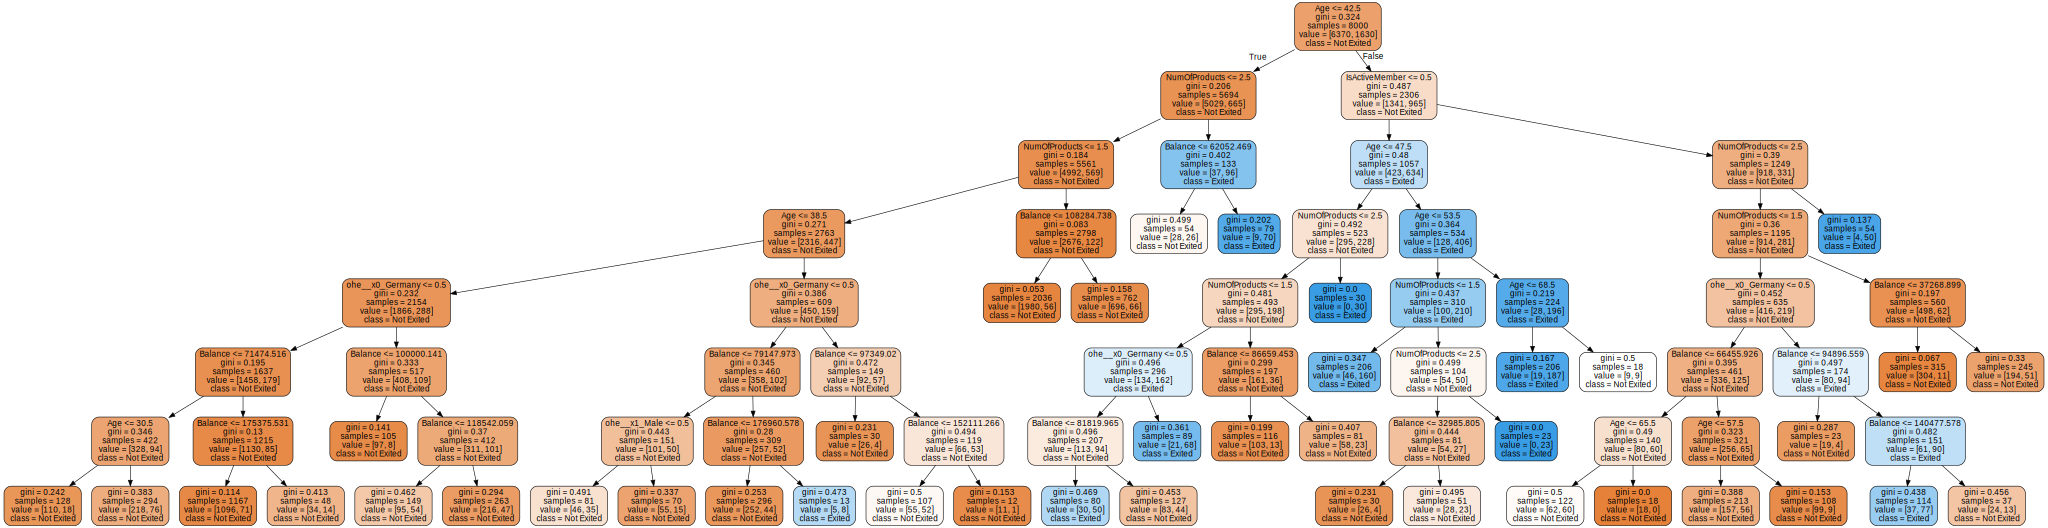

In [77]:
graphdata = tree.export_graphviz(model4,class_names=['Not Exited','Exited'],
                            feature_names=prep.get_feature_names(),filled=True,rounded=True)
graph = graphviz.Source(graphdata)
graph

In [78]:
graph.format = 'png'
graph.render("mydtree",view=True)

'mydtree.png'

## Random Forest Implementation

In [79]:
from sklearn.ensemble import RandomForestClassifier

model5 = RandomForestClassifier(n_estimators=200,random_state=5,max_depth=9,oob_score=True,min_samples_leaf=5,
                               class_weight='balanced')

# train the model with train data
model5.fit(xtrain,ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=5,
                       n_estimators=200, oob_score=True, random_state=5)

In [80]:
# assess the performance on test data
# performance analysis using test data
ypred = model5.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1593
           1       0.58      0.74      0.65       407

    accuracy                           0.84      2000
   macro avg       0.75      0.80      0.77      2000
weighted avg       0.86      0.84      0.84      2000



## Adaboost implementation

In [81]:
from sklearn.ensemble import AdaBoostClassifier

model6 = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(criterion='gini',class_weight='balanced',
                                                                      max_depth=1,),n_estimators=300)
model6.fit(xtrain,ytrain)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   n_estimators=300)

In [82]:
# performance analysis using test data
ypred = model6.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.48      0.75      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.78      0.80      2000



## Gradient boosting

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
model7 = GradientBoostingClassifier(learning_rate=0.02,n_estimators=1000,tol=0.00001,max_depth=2)
model7.fit(xtrain,ytrain)

GradientBoostingClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000,
                           tol=1e-05)

In [84]:
# performance analysis using test data
ypred = model7.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.48      0.59       407

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000



## XGBoost

In [85]:
# pip install xgboost

In [86]:
from xgboost import XGBClassifier
model9 = XGBClassifier(n_estimators=500,n_jobs=-1)

In [87]:
model9.fit(xtrain,ytrain)

XGBClassifier(n_estimators=500, n_jobs=-1)

In [88]:
# performance analysis using test data
ypred = model9.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.74      0.49      0.59       407

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



## Stacking

In [91]:
# pip install mlxtend

In [94]:

# !pip install six

In [96]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier


base1 = KNeighborsClassifier(n_neighbors=3)
base2 = DecisionTreeClassifier(random_state=3,class_weight='balanced',max_depth=8,min_samples_leaf=10)
base3 = AdaBoostClassifier(n_estimators=500,random_state=3)
base4 = RandomForestClassifier(n_estimators=500,random_state=3,class_weight='balanced')


meta = LogisticRegression()

model9 = StackingClassifier(classifiers=[base1,base2,base3,base4],meta_classifier=meta)
model9.fit(xtrain,ytrain)

StackingClassifier(classifiers=[KNeighborsClassifier(n_neighbors=3),
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=8,
                                                       min_samples_leaf=10,
                                                       random_state=3),
                                AdaBoostClassifier(n_estimators=500,
                                                   random_state=3),
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=500,
                                                       random_state=3)],
                   meta_classifier=LogisticRegression())

In [97]:
# assess the performance on test data
# performance analysis using test data
ypred = model9.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.74      0.51      0.60       407

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [98]:
import joblib
joblib.dump(model4,'model.pkl')

['model.pkl']

In [99]:
joblib.dump(prep,"preprocesser.pkl")

['preprocesser.pkl']